In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.models import load_model
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore') 


In [10]:

train = pd.read_csv('mitbih_train.csv',header=None)
test = pd.read_csv('mitbih_test.csv',header=None)

In [11]:
train[187]=train[187].astype(int)
train.shape
test.shape


(21892, 188)

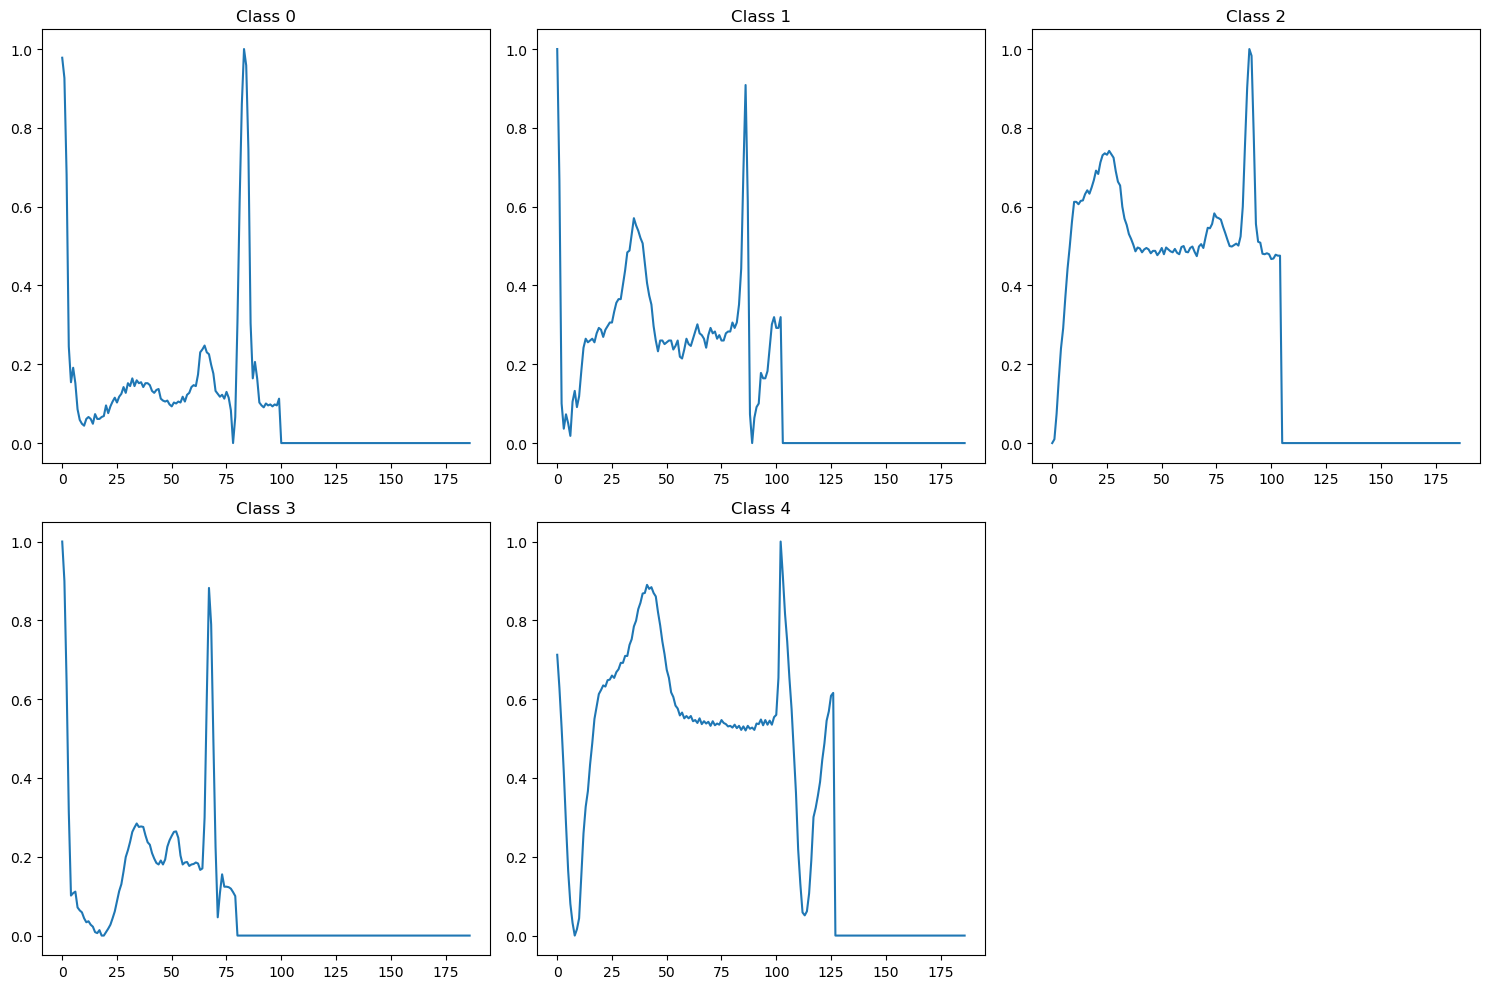

In [12]:
classes = train.iloc[:, -1].unique()
plt.figure(figsize=(15, 10))
for i, cls in enumerate(classes):
    plt.subplot(2, 3, i + 1)
    sample = train[train.iloc[:, -1] == cls].iloc[0, :-1]
    plt.plot(sample.values)
    plt.title(f'Class {cls}')
plt.tight_layout()
plt.show()

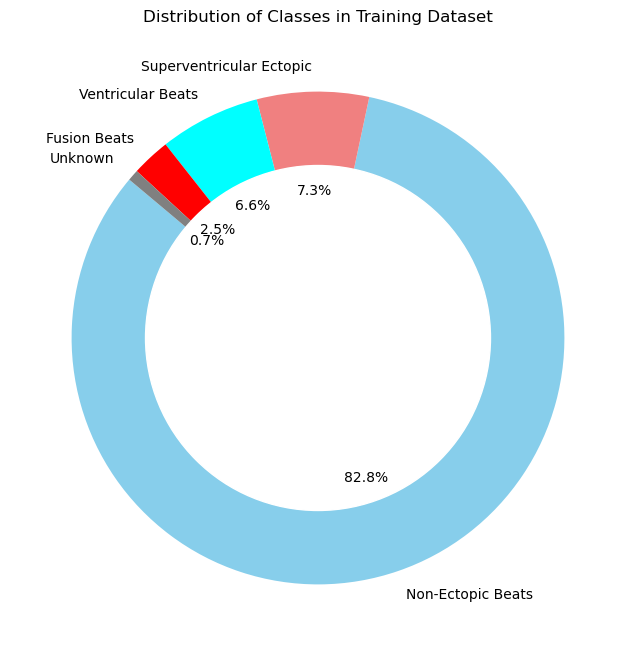

In [13]:
class_counts = train.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(class_counts, labels=['Non-Ectopic Beats', 'Superventricular Ectopic', 'Ventricular Beats',
                              'Fusion Beats', 'Unknown'],
        colors=['skyblue', 'lightcoral', 'cyan', 'red', 'grey'], autopct='%1.1f%%', startangle=140)
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Classes in Training Dataset')
plt.show()

In [14]:

df_1 = train[train.iloc[:, -1] == 1]
df_2 = train[train.iloc[:, -1] == 2]
df_3 = train[train.iloc[:, -1] == 3]
df_4 = train[train.iloc[:, -1] == 4]


df_1_upsample = resample(df_1, n_samples = 20000, replace = True, random_state = 123)
df_2_upsample = resample(df_2, n_samples = 20000, replace = True, random_state = 123)
df_3_upsample = resample(df_3, n_samples = 20000, replace = True, random_state = 123)
df_4_upsample = resample(df_4, n_samples = 20000, replace = True, random_state = 123)
df_0 = train[train[187]==0].sample(n =20000, random_state=123)
train_df = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [15]:

c=train_df[187].value_counts()
print(c)


187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


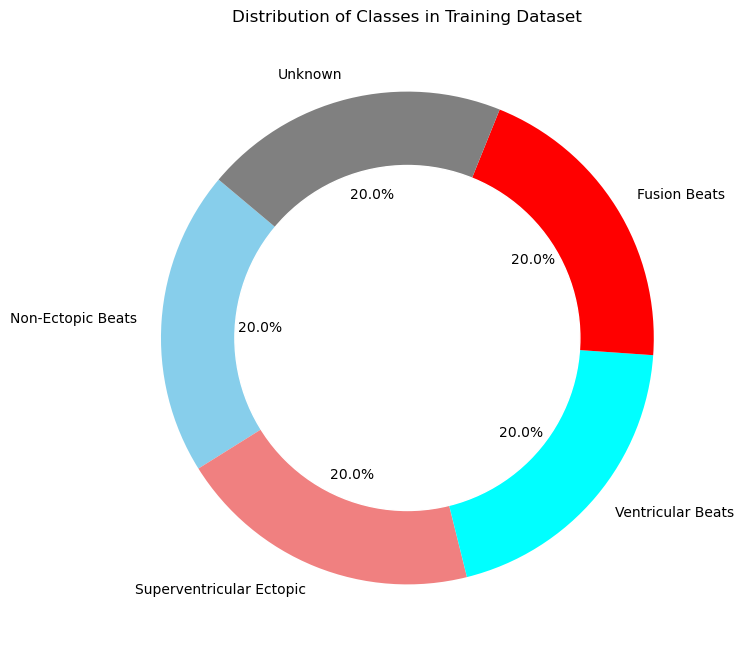

In [16]:
class_counts = train_df.iloc[:, -1].value_counts()
plt.figure(figsize=(10, 8))
circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(class_counts, labels=['Non-Ectopic Beats', 'Superventricular Ectopic', 'Ventricular Beats',
                              'Fusion Beats', 'Unknown'],
        colors=['skyblue', 'lightcoral', 'cyan', 'red', 'grey'], autopct='%1.1f%%', startangle=140)
p = plt.gcf()
p.gca().add_artist(circle)
plt.title('Distribution of Classes in Training Dataset')
plt.show()


In [17]:

# making train & test splits
X_train = train_df.iloc[:, :-1].values
X_test = test.iloc[:, :-1].values 
y_train = train_df.iloc[:, -1].values
y_test = test.iloc[:, -1].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187)
(21892, 187)
(100000,)
(21892,)


In [18]:
#Convolutional Neural Network (CNN)

cnn = Sequential()
cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same', input_shape=(187, 1)))
cnn.add(BatchNormalization())

cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

cnn.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(5, activation='softmax'))


In [19]:
# Compile the model
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True, 
    verbose=1
)

cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 187, 64)        │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 187, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 94, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 94, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 94, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 47, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 47, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 47, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        98,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,349 (599.02 KB)

 Trainable params: 152,965 (597.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Train the model
history = cnn.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),  
    epochs=50,            
    batch_size=32,
    callbacks=[early_stopping]
)


loss , acc = cnn.evaluate(X_test , y_test)
print('loss:' , loss*100)
print('accuracy: ' , acc*100)

Epoch 1/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 32ms/step - accuracy: 0.8970 - loss: 0.2851 - val_accuracy: 0.9283 - val_loss: 0.2008
Epoch 2/50
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 106s 34ms/step - accuracy: 0.9734 - loss: 0.0777 - val_accuracy: 0.9624 - val_loss: 0.1278
Epoch 3/50
2812/3125 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.9823 - loss: 0.0528

In [ ]:

history = history.history
epochs = range(1, len(history['loss']) + 1)
acc = history['accuracy']
loss = history['loss']
val_acc = history['val_accuracy']
val_loss = history['val_loss']

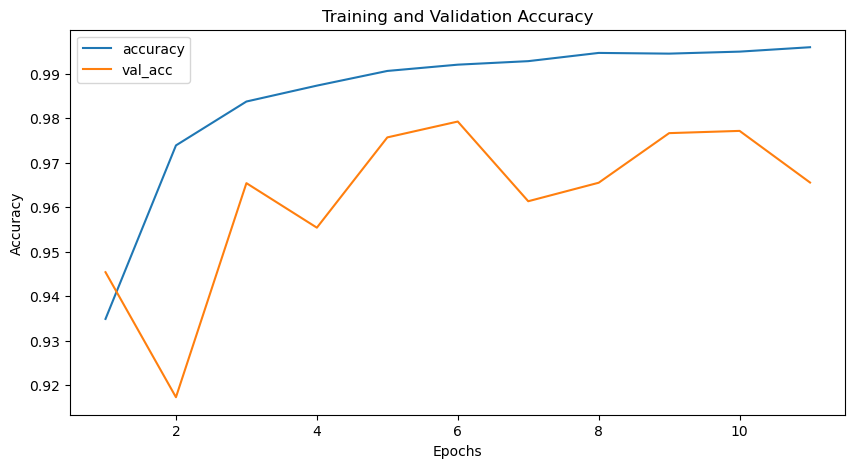

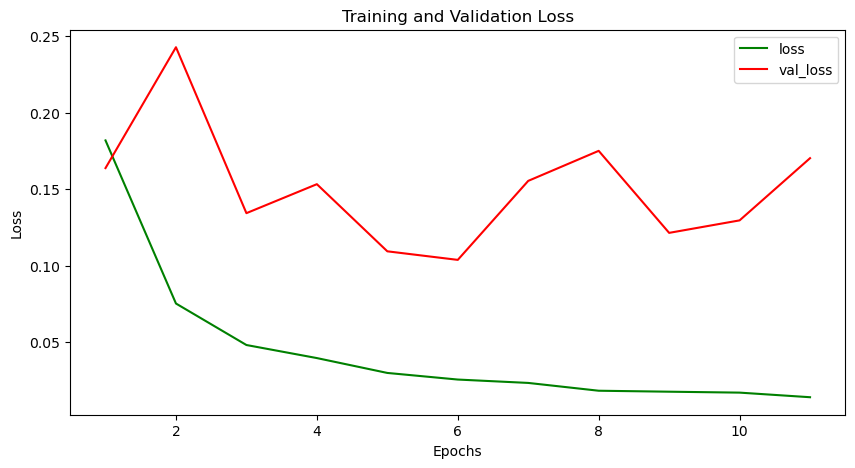

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()
plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()


In [ ]:
# Get predictions from the model
y_pred = cnn.predict(X_test)
y_true = y_test  
y_pred_classes = np.argmax(y_pred, axis=1)  

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100


685/685 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step


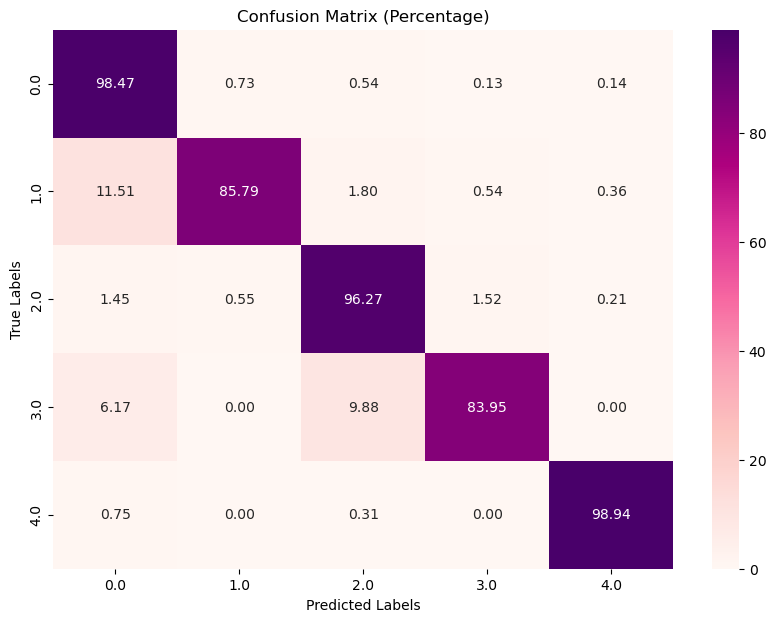

In [ ]:
# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdPu', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



In [ ]:
# Generate Classification Report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.98      0.99     18118
         1.0       0.77      0.86      0.81       556
         2.0       0.92      0.96      0.94      1448
         3.0       0.74      0.84      0.79       162
         4.0       0.98      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.88      0.93      0.90     21892
weighted avg       0.98      0.98      0.98     21892

Model Accuracy: 0.98


In [ ]:
# Multi-Layer Perceptron (MLP) 
model = Sequential()
model.add(Dense(187,activation='relu' , input_shape=(187,)))
model.add(Dense(100 , activation='relu'))
model.add(Dense(5,activation='softmax'))
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,          
    restore_best_weights=True, 
    verbose=1
)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 187)            │        35,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        18,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,461 (212.74 KB)

 Trainable params: 54,461 (212.74 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
his = model.fit(X_train , y_train ,
                batch_size=128,
                validation_data=(X_test , y_test) ,
                callbacks=[early_stopping],
                epochs=50 , verbose=True)

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.7621 - loss: 0.6620 - val_accuracy: 0.8555 - val_loss: 0.4241
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8982 - loss: 0.2770 - val_accuracy: 0.8814 - val_loss: 0.3242
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9285 - loss: 0.2039 - val_accuracy: 0.8626 - val_loss: 0.3596
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9455 - loss: 0.1616 - val_accuracy: 0.8573 - val_loss: 0.3785
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9516 - loss: 0.1389 - val_accuracy: 0.9038 - val_loss: 0.2629
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9599 - loss: 0.1189 - val_accuracy: 0.9400 - val_loss: 0.1907
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9661 - loss: 0.1011 - val_accuracy: 0.9167 - val_loss: 0.2519
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9693 - loss: 0.0904 - val_accuracy: 0

In [ ]:
# Get predictions from the model
y_pred = model.predict(X_test)
y_true = y_test  
y_pred_classes = np.argmax(y_pred, axis=1) 

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


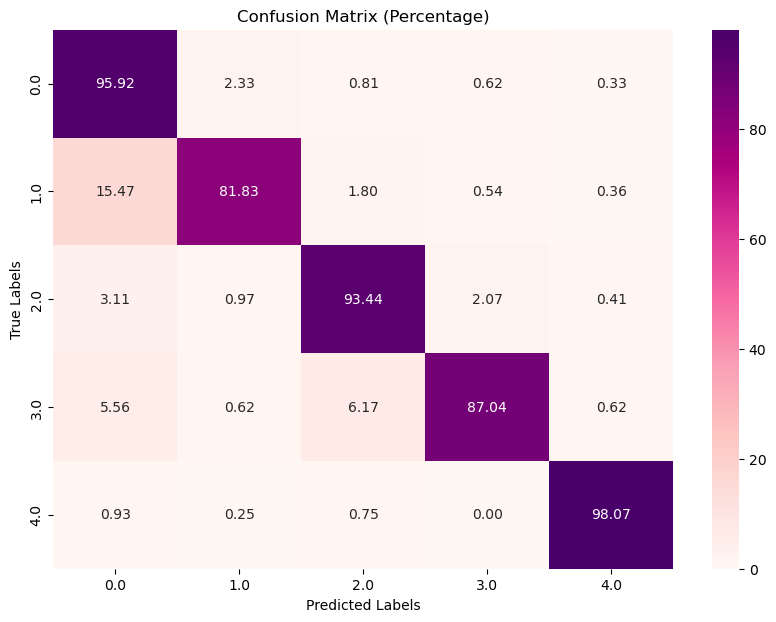

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot Confusion Matrix Heatmap (as Percentages)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdPu', 
            xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
# Generate Classification Report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     18118
         1.0       0.51      0.82      0.63       556
         2.0       0.88      0.93      0.91      1448
         3.0       0.49      0.87      0.63       162
         4.0       0.96      0.98      0.97      1608

    accuracy                           0.95     21892
   macro avg       0.77      0.91      0.82     21892
weighted avg       0.97      0.95      0.96     21892



In [ ]:
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.95


In [ ]:
# Check if model exists in your environment
if 'model' in locals():
    model.save('project_model.h5')
else:
    print("Error: No model defined. Please create your model first.")

Error: No model defined. Please create your model first.
